# Specific Test V. Exploring Transformers 

> Three different transformer models were used for this test. This notebook contains the results of the RegionViT model.

**Task:** Use a vision transformer method of your choice to build a robust and efficient model for binary classification or unsupervised anomaly detection on the provided dataset. In the case of unsupervised anomaly detection, train your model to learn the distribution of the provided strong lensing images with no substructure. Please implement your approach in PyTorch or Keras and discuss your strategy.

**Dataset Description:** A set of simulated strong gravitational lensing images with and without substructure. 

**Evaluation Metrics:** ROC curve (Receiver Operating Characteristic curve) and AUC score (Area Under the ROC Curve)

## Strategy

A [RegionViT model](https://arxiv.org/pdf/2106.02689.pdf) was used for classification. The RegionViT model is a vision transformer model that uses a region-based approach to extract features from images.

The model was trained on the provided dataset for 30 epochs with an initial learning rate of 0.0001. Adam optimiser was used for training and StepLR was used for learning rate scheduling with a step size of 10 and gamma 0.1.

The dataset is split in a 9:1 train-test ratio. The training set is resized to 224*224 image and augmented using ColorJitter, RandomHorizontalFlip and RandomRotation. The test set is only resized and not augmented.

## Results

**ROC-AUC Score:** 0.9891319999999999

**Training Curve:**

![Training Curve](../results/test-5-regionvit-training-plot.png)

**ROC Curve:**

![ROC Curve](../results/test-5-regionvit-roc-plot.png)

In [4]:
!pip install vit-pytorch

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


## Importing Libraries

In [5]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import os
from PIL import Image
from tqdm import tqdm
import seaborn as sns

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Loading Data

In [6]:
base_dir = '../datasets/test5/lenses'

train_df = pd.DataFrame(columns = ['path', 'label'])

label_map = {'no_sub':0, 'sub':1}
val_label_map = {0:'no_sub', 1:'sub'}

for i in label_map.keys():
    entries = [os.path.join(base_dir, i, j) for j in os.listdir(os.path.join(base_dir, i))]
    temp_df = pd.DataFrame({'path':entries, 'label':i})
    train_df = pd.concat([train_df, temp_df], ignore_index=True)

train_df.head()

,path,label
0,../datasets/test5/lenses/no_sub/image_17478751...,no_sub
1,../datasets/test5/lenses/no_sub/image_58501840...,no_sub
2,../datasets/test5/lenses/no_sub/image_20642528...,no_sub
3,../datasets/test5/lenses/no_sub/image_22438675...,no_sub
4,../datasets/test5/lenses/no_sub/image_27048203...,no_sub


In [7]:
train_df, test_df = train_test_split(train_df, test_size=0.1, random_state=42, stratify=train_df['label'])

print(f"Train split:\n{train_df['label'].value_counts()}\n")
print(f"Test split:\n{test_df['label'].value_counts()}")

Train split:
sub       4500
no_sub    4500
Name: label, dtype: int64

Test split:
sub       500
no_sub    500
Name: label, dtype: int64


In [8]:
class Dataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['path']
        img = Image.open(img_path).convert('RGB')
        
        if self.transform:
            img = self.transform(img)

        label = self.df.iloc[idx]['label']
        label = label_map[label]
        
        return img, label

In [9]:
train_transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomRotation(180),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor()
])

train_dataset = Dataset(train_df, transform=train_transforms)
test_dataset = Dataset(test_df, transform=test_transforms)

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

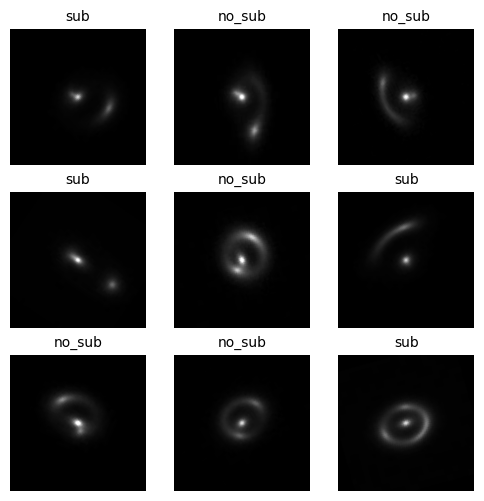

In [13]:
def show_batch(images, labels, class_map):
    fig, ax = plt.subplots(3, 3, figsize=(6, 6))
    for i in range(3):
        for j in range(3):
            image = images[i*3 + j]
            label = labels[i*3 + j].item()
            ax[i][j].imshow(image.permute(1, 2, 0))
            title = class_map[label]
            ax[i][j].set_title(title)
            ax[i][j].axis('off')
            ax[i][j].title.set_fontsize(10)

    plt.show()

images, labels = next(iter(train_loader))
show_batch(images, labels, val_label_map)

## Defining Model

In [46]:
import torch
from vit_pytorch.regionvit import RegionViT

model = RegionViT(
    dim = (64, 128, 256, 512),      
    depth = (2, 2, 8, 2),           
    window_size = 7,                
    num_classes = 2,             
    tokenize_local_3_conv = False,  
    use_peg = False,
).to(device)

## Hyper-parameters and Training

In [47]:
def train(model, epochs, optimizer, criterion, scheduler, device, trainloader, testloader):

    train_losses = []
    train_acc = []
    test_losses = []
    test_acc = []
        
    for i in range(epochs):
        running_loss = 0.0
        running_correct = 0
        total = 0
        best_acc = 0.0
        
        print(f"Epoch: {i + 1}")
        
        for images, targets in tqdm(trainloader, desc= "Train\t"):
            
            images, targets = images.to(device), targets.to(device)
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            pred = torch.argmax(output, dim=1)
        
            running_correct += (pred == targets).sum().item()
            total += targets.size(0)

        scheduler.step()
        
        train_losses.append(running_loss / len(trainloader))
        train_acc.append(running_correct / total)

        running_val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():

            for images, targets in tqdm(testloader, desc= "Test\t"):
                images, targets = images.to(device), targets.to(device)

                output = model(images)
                preds = torch.argmax(output, dim=1)

                correct += (preds == targets).sum().item()
                running_val_loss += criterion(output, targets).item()
                total += targets.size(0)

            acc = correct / total
            test_acc.append(acc)
            test_losses.append(running_val_loss / len(testloader))

        if test_acc[-1] > best_acc:
            best_acc = test_acc[-1]
            torch.save(model.state_dict(), 'best_model.pth') 

        print(f"Train Loss: {train_losses[-1]:.3f}, Train Acc: {train_acc[-1]:.3f}, Test Loss: {test_losses[-1]:.3f}, Test Acc: {test_acc[-1]:.3f}\n")

    return train_losses, train_acc, test_losses, test_acc, best_acc

In [48]:
epochs = 30
lr = 0.0001
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [49]:
train_losses, train_acc, test_losses, test_acc, best_acc = train(model, epochs, optimizer, loss_function, scheduler, device, train_loader, test_loader)

Epoch: 1


Test	: 100%|██████████| 16/16 [00:03<00:00,  4.74it/s]


Train Loss: 0.742, Train Acc: 0.504, Test Loss: 0.693, Test Acc: 0.500

Epoch: 2


Test	: 100%|██████████| 16/16 [00:03<00:00,  4.29it/s]


Train Loss: 0.700, Train Acc: 0.496, Test Loss: 0.706, Test Acc: 0.500

Epoch: 3


Test	: 100%|██████████| 16/16 [00:03<00:00,  4.65it/s]


Train Loss: 0.698, Train Acc: 0.497, Test Loss: 0.694, Test Acc: 0.500

Epoch: 4


Test	: 100%|██████████| 16/16 [00:03<00:00,  4.87it/s]


Train Loss: 0.700, Train Acc: 0.499, Test Loss: 0.694, Test Acc: 0.500

Epoch: 5


Test	: 100%|██████████| 16/16 [00:03<00:00,  4.37it/s]


Train Loss: 0.700, Train Acc: 0.502, Test Loss: 0.693, Test Acc: 0.500

Epoch: 6


Test	: 100%|██████████| 16/16 [00:03<00:00,  4.62it/s]


Train Loss: 0.676, Train Acc: 0.562, Test Loss: 0.663, Test Acc: 0.582

Epoch: 7


Test	: 100%|██████████| 16/16 [00:03<00:00,  4.66it/s]


Train Loss: 0.583, Train Acc: 0.647, Test Loss: 0.510, Test Acc: 0.683

Epoch: 8


Test	: 100%|██████████| 16/16 [00:03<00:00,  4.54it/s]


Train Loss: 0.548, Train Acc: 0.669, Test Loss: 0.414, Test Acc: 0.747

Epoch: 9


Test	: 100%|██████████| 16/16 [00:03<00:00,  4.36it/s]


Train Loss: 0.440, Train Acc: 0.747, Test Loss: 0.449, Test Acc: 0.728

Epoch: 10


Test	: 100%|██████████| 16/16 [00:03<00:00,  4.60it/s]


Train Loss: 0.380, Train Acc: 0.788, Test Loss: 0.313, Test Acc: 0.838

Epoch: 11


Test	: 100%|██████████| 16/16 [00:03<00:00,  4.47it/s]


Train Loss: 0.284, Train Acc: 0.847, Test Loss: 0.236, Test Acc: 0.869

Epoch: 12


Test	: 100%|██████████| 16/16 [00:03<00:00,  4.56it/s]


Train Loss: 0.258, Train Acc: 0.860, Test Loss: 0.219, Test Acc: 0.882

Epoch: 13


Test	: 100%|██████████| 16/16 [00:03<00:00,  4.28it/s]


Train Loss: 0.231, Train Acc: 0.882, Test Loss: 0.200, Test Acc: 0.903

Epoch: 14


Test	: 100%|██████████| 16/16 [00:03<00:00,  4.71it/s]


Train Loss: 0.220, Train Acc: 0.888, Test Loss: 0.200, Test Acc: 0.902

Epoch: 15


Test	: 100%|██████████| 16/16 [00:03<00:00,  5.27it/s]


Train Loss: 0.205, Train Acc: 0.898, Test Loss: 0.191, Test Acc: 0.913

Epoch: 16


Test	: 100%|██████████| 16/16 [00:03<00:00,  4.40it/s]


Train Loss: 0.192, Train Acc: 0.909, Test Loss: 0.196, Test Acc: 0.912

Epoch: 17


Test	: 100%|██████████| 16/16 [00:03<00:00,  5.03it/s]


Train Loss: 0.180, Train Acc: 0.915, Test Loss: 0.173, Test Acc: 0.917

Epoch: 18


Test	: 100%|██████████| 16/16 [00:03<00:00,  5.33it/s]


Train Loss: 0.170, Train Acc: 0.919, Test Loss: 0.172, Test Acc: 0.930

Epoch: 19


Test	: 100%|██████████| 16/16 [00:03<00:00,  4.92it/s]


Train Loss: 0.164, Train Acc: 0.922, Test Loss: 0.168, Test Acc: 0.930

Epoch: 20


Test	: 100%|██████████| 16/16 [00:03<00:00,  5.33it/s]


Train Loss: 0.159, Train Acc: 0.926, Test Loss: 0.163, Test Acc: 0.929

Epoch: 21


Test	: 100%|██████████| 16/16 [00:02<00:00,  5.41it/s]


Train Loss: 0.144, Train Acc: 0.934, Test Loss: 0.137, Test Acc: 0.941

Epoch: 22


Test	: 100%|██████████| 16/16 [00:03<00:00,  5.06it/s]


Train Loss: 0.138, Train Acc: 0.937, Test Loss: 0.135, Test Acc: 0.949

Epoch: 23


Test	: 100%|██████████| 16/16 [00:03<00:00,  5.32it/s]


Train Loss: 0.136, Train Acc: 0.941, Test Loss: 0.138, Test Acc: 0.943

Epoch: 24


Test	: 100%|██████████| 16/16 [00:02<00:00,  5.43it/s]


Train Loss: 0.127, Train Acc: 0.946, Test Loss: 0.135, Test Acc: 0.938

Epoch: 25


Test	: 100%|██████████| 16/16 [00:03<00:00,  4.97it/s]


Train Loss: 0.132, Train Acc: 0.938, Test Loss: 0.131, Test Acc: 0.940

Epoch: 26


Test	: 100%|██████████| 16/16 [00:02<00:00,  5.37it/s]


Train Loss: 0.132, Train Acc: 0.939, Test Loss: 0.128, Test Acc: 0.944

Epoch: 27


Test	: 100%|██████████| 16/16 [00:02<00:00,  5.50it/s]


Train Loss: 0.128, Train Acc: 0.942, Test Loss: 0.131, Test Acc: 0.942

Epoch: 28


Test	: 100%|██████████| 16/16 [00:03<00:00,  5.13it/s]


Train Loss: 0.129, Train Acc: 0.941, Test Loss: 0.127, Test Acc: 0.942

Epoch: 29


Test	: 100%|██████████| 16/16 [00:03<00:00,  5.27it/s]


Train Loss: 0.134, Train Acc: 0.939, Test Loss: 0.126, Test Acc: 0.945

Epoch: 30


Test	: 100%|██████████| 16/16 [00:02<00:00,  5.39it/s]


Train Loss: 0.128, Train Acc: 0.942, Test Loss: 0.129, Test Acc: 0.942



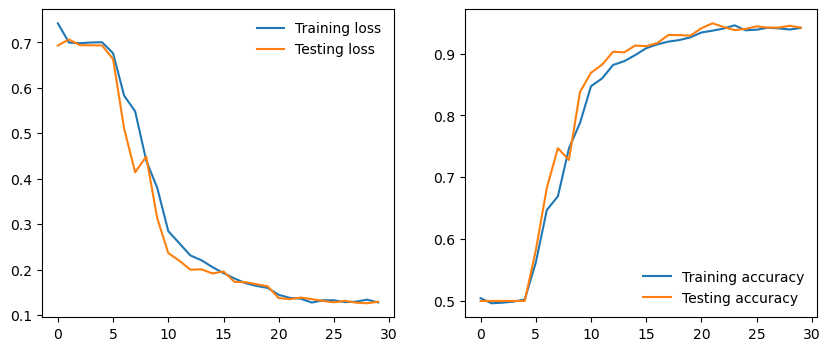

In [50]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Testing loss')
plt.legend(frameon=False)

plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training accuracy')
plt.plot(test_acc, label='Testing accuracy')
plt.legend(frameon=False)

## Testing

The best model is loaded for testing and the results are plotted.

In [52]:
model = RegionViT(
    dim = (64, 128, 256, 512),      # tuple of size 4, indicating dimension at each stage
    depth = (2, 2, 8, 2),           # depth of the region to local transformer at each stage
    window_size = 7,                # window size, which should be either 7 or 14
    num_classes = 2,             # number of output classes
    tokenize_local_3_conv = False,  # whether to use a 3 layer convolution to encode the local tokens from the image. the paper uses this for the smaller models, but uses only 1 conv (set to False) for the larger models
    use_peg = False,                # whether to use positional generating module. they used this for object detection for a boost in performance
).to(device)
model.load_state_dict(torch.load('best_model.pth'))

<All keys matched successfully>

In [53]:
y_true = []
y_pred_class = []
y_pred_prob = []

with torch.no_grad():
    for images, targets in tqdm(test_loader):
        images, targets = images.to(device), targets.to(device)
        output = model(images)
        preds = torch.argmax(output, dim=1)
        y_true.extend(targets.cpu().numpy())
        y_pred_class.extend(preds.cpu().numpy())
        y_pred_prob.extend(output.cpu().numpy())

100%|██████████| 16/16 [00:03<00:00,  4.73it/s]


In [54]:
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, classification_report, auc

print(classification_report(y_true, y_pred_class, target_names=label_map.keys()))

              precision    recall  f1-score   support

      no_sub       0.94      0.95      0.94       500
         sub       0.95      0.93      0.94       500

    accuracy                           0.94      1000
   macro avg       0.94      0.94      0.94      1000
weighted avg       0.94      0.94      0.94      1000



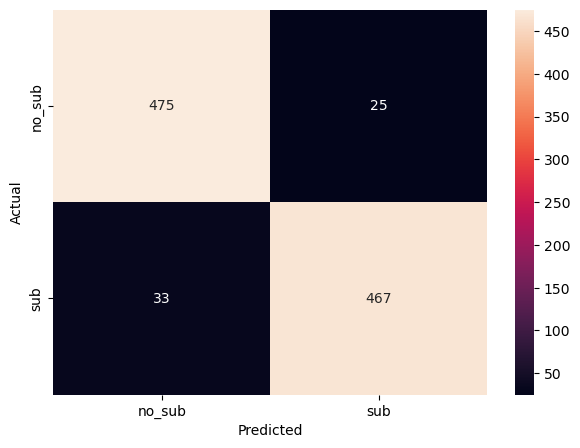

In [55]:
conf_matrix = confusion_matrix(y_true, y_pred_class)
plt.figure(figsize=(7, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=label_map.keys(), yticklabels=label_map.keys())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [56]:
print(f"ROC-AUC Score: {roc_auc_score(y_true, np.array(y_pred_prob)[:,1], multi_class='ovr')}")

ROC-AUC Score: 0.9891319999999999


no_sub   ROC-AUC: 0.9902
sub      ROC-AUC: 0.9891319999999999


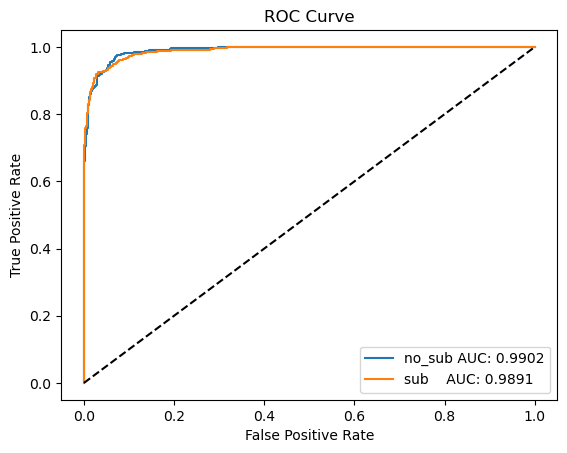

In [57]:
y_true_dummies = pd.get_dummies(y_true).values

auc_scores = {}
for i in range(2):
    fpr_i, tpr_i, thresholds_i = roc_curve(y_true_dummies[:, i], np.array(y_pred_prob)[:, i])
    auc_score = auc(fpr_i, tpr_i)
    print(f"{(val_label_map[i]).ljust(8)} ROC-AUC: {auc_score}")
    auc_scores[val_label_map[i]] = auc_score
    plt.plot(fpr_i, tpr_i, label=f"{(val_label_map[i]).ljust(6)} AUC: {auc_score:.4f}")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()